# Classifying Architectural Building Typologies Using Unsupervised Learning

## MLND Capstone
Jim Peraino
November 12th, 2017

## I. Definition

### Project Overview

In the domains of architecture and urban planning, building typology is an often referenced idea when analyzing neighbordhoods, buildings, and public spaces. Historically, buildings have been classified in two primary ways: by form (or shape), and by use (what happens inside). In the early 19th century, the architect Jean-Nicolas-Louis Durand proposed the notion of architectural typology in his book Precis des Lecons d'Architecture (1). Since then, many efforts have been made to apply machine learning techniques to Urban Design and Architectural analysis, including with software such as GIS (2) and spatial recognition systems for identifying ideal sites for new development projects (3).

As an architect myself, I'm curious about ways that we can quantify qualitative information about buildings, and vice versa. There are relatively few datasets in the field of architecture, and establishing and automating methods for classifying buildings, in particular into qualitative categories, will be essential in this endeavor. Being able to classify a building as a certain typology enables many other kinds of analysis. This information can be used to assess the characteristics of a neighborhood, predict property values, identify areas for new development, or countless other tasks related to the built environment.

### Problem Statement

Databases of building typologies do not exist for most of the world. To exacerbate this problem, buildings often no longer limit themselves to the typical typologies (schools, homes, hospitals, churches, for instance), and instead, are often mixed-use. However, physical charactistics of buildings can be easily observed or deduced from satelite images (3). 

__The problem, then, is: How can we automate the process of classifying buildings into their respective typologies by analyzing this physical information?__

The problem is quantifiable and measurable because we can logically assess any individual building as to the makeup of its use. It is a problem that is replicable anywhere on earth that there are buildings, since google earth shows satelite images from which we can mine physical data.

Unsupervised learning can be used on this task. As was used in the Customer Segment project, this solution can follow the process of: Data Exploration, Data Preprocessing, Feature Transformation, Clustering, and drawing conlusions(5). For more detail, see the project design section. 

New York City's Department of City Planning puts out a dataset called The Primary Land Use Tax Lot Output (PLUTO),  which contain information about plots of lands, the characteristics of the buildings on that land, and various administrative districts. This dataset was obtained as a download from Kaggle (4). This dataset contains information for over 65,000 lots. 

Since my goal is to use physical characteristics to classify buildings into typological groups, I will test different combinations of Physical Characteristics to see which best enable clustering of the data into building typologies. I will then compare the percentages of commercial/residential/office etc. floor areas in each cluster to better understand and evaluate the clusters.

### Metrics

The evaluation metric will be the extent to which each cluster is homogenous in terms of its program (residential, retail, etc). This can be determined by calculating the standard deviation of the primary programmatic element in  each cluster. A smaller standard deviation would indicate that the cluster is more homogeneous, and a larger standard deviation would indicate that it is heterogeneous. 



## II. Analysis

### Data Exploration

__Dataset Features__

While the dataset has roughly 80 variables for each lot, those of particular interest are:

__Physical Characteristics__ (Used to create the model)
* Total Building Floor Area
* Lot Area 
* Number of Floors
* Lot Frontage
* Lot Depth
* Building Frontage
* Building Depth
* Floor Area Ration (FAR)

__Other Data__ (Used as the benchmark)
* Commercial, Residential, Office, Retail, Factory, Storage, Garage, and Other Floor Area
* Building Class
* Zoning District

In [1]:
### SOURCE: Code is based on Udacity MLND Customer Segments Project
# Import libaries necessary for this project
import numpy as np
import pandas as pd
from IPython.display import display

# Import supplementary visualizations code visuals code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Define column sets
col_Import = ["Address", "LotArea", "BldgArea", "BldgFront", "BldgDepth", "NumFloors", "NumBldgs", "LotFront", "LotDepth"]
col_Phys = ["BldgFront", "BldgDepth"]
col_PhysPlus = ["BldgFront", "BldgDepth", "FlrShape", "FAR2", "NumFloors"]

# Load the PLUTO Buildings Dataset for Brooklyn
try: 
    data = pd.read_csv("BK.csv", 
            low_memory=False,
            # Dataset has 80+ features, so load only those which are relevant
            #usecols=["Address", "LotArea", "BldgArea", "BldgFront", "BldgDepth", "NumFloors", "NumBldgs", "LotFront", "LotDepth", "ComArea", "ResArea", "OfficeArea", "RetailArea", "GarageArea", "StrgeArea", "FactryArea"])
            usecols= col_Import)
            
        
    print "PLUTO Brooklyn Dataset has {} samples with {} features each.".format(*data.shape)
    
except:
    print "Dataset could not be loaded."

PLUTO Brooklyn Dataset has 277131 samples with 9 features each.


In [2]:
# Display a description of the dataset
display(data.describe())

,LotArea,BldgArea,NumBldgs,NumFloors,LotFront,LotDepth,BldgFront,BldgDepth
count,2.771310e+05,2.771310e+05,277131.000000,277131.000000,277131.000000,277131.000000,277131.000000,277131.000000
mean,6.028453e+03,5.177061e+03,1.211665,2.296141,32.246961,100.567182,24.067890,49.746923
std,4.300028e+05,5.477153e+04,0.913857,1.200165,58.948294,49.369778,33.224805,35.316955
min,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.900000e+03,1.648000e+03,1.000000,2.000000,20.000000,100.000000,18.000000,38.000000
50%,2.134000e+03,2.368000e+03,1.000000,2.000000,22.000000,100.000000,20.000000,46.000000
75%,2.833000e+03,3.312000e+03,1.000000,3.000000,28.920000,100.000000,22.000000,57.000000
max,2.073912e+08,2.400000e+07,236.000000,119.000000,9999.000000,7960.000000,6020.000000,7360.000000


__Dataset Statistics__
As noted in the table above, there is a large range in the physical characteristics in the data. The number of floors in the middle 50% of the data ranges from 2-3 floors, however the maximum number of floors is 119. This makes sense when thinking about a city composed mostly of small buildings but with several taller buildings near its downtown area. This trend persists throughout the building characteristics, with characteristics such as Lot Front and Lot Depth staying relatively consistently between 20 and 100' for more than 50% of the data, but with significant shifts at the upper end (with some lot depths more than a mile long). Tall buildings are not outliers in this case, since they are a distinct typology, they just occur less often, so we will need to be sure to pick samples that account for this. 

__Abnormalities__
The dataset includes all lots in Brooklyn, even those without buildings. These will need to be removed as outliers/irrelevant because including them results in several features being listed with values of zero (Number of Floors, Building Front, etc). Notably, large buildings should *not* be removed as outliers since they may correspond to a specific type of building. 

Empty lots are removed from the data below.

__Selecting Samples__

Several representative building types are identified to put real buildings to the data.

* Mid-sized Retail Building: 128 Court Street
* Large Office Building: 345 Adams Street
* Single Family Row House: 590 11 Street
* Large Apartment Building: 235 Gold Street

In [3]:
# Identify addresses for samples
addresses = ['128 COURT STREET', '345 ADAMS STREET', '590 11 STREET', '235 GOLD STREET']
indices = []

# Get index of each sample
for i in addresses:
    index = data[data.Address == i].index[0]
    indices.append(index)

# Create a DataFrame of the chosen samples
samples = pd.DataFrame(data.loc[indices], columns = data.keys()).reset_index(drop = True)
print "Chosen samples from PLUTO database:"
display(samples)

Chosen samples from PLUTO database:


,Address,LotArea,BldgArea,NumBldgs,NumFloors,LotFront,LotDepth,BldgFront,BldgDepth
0,128 COURT STREET,14518,28150,1,1.0,138.31,100.00,65.00,137.50
1,345 ADAMS STREET,25056,297845,1,14.0,261.75,97.87,261.00,97.87
2,590 11 STREET,1858,2526,1,2.0,18.58,100.00,18.58,44.00
3,235 GOLD STREET,39930,326609,1,12.0,315.25,93.58,315.00,90.00


In [4]:
# Limit samples to sites with only one building
data = data[data.NumBldgs == 1]

# Remove samples with no data for physical characteristics
data = data[data.NumFloors != 0]
data = data[data.BldgFront != 0]
data = data[data.BldgDepth != 0]
data = data[data.LotFront != 0]
data = data[data.LotDepth != 0]

# Reduce data size by randomly select indices to create a sample.
import random
random.seed(a = 35)

# Reduce data set by roughly 90%
for i in range(20000):
    indices.append(random.randrange(0, 200000, 1))

dataReduced = pd.DataFrame(data.loc[indices], columns = data.keys()).reset_index(drop = True)

# Display a new description of the dataset
print "The reduced PLUTO Brooklyn Dataset has {} samples with {} features each.".format(*dataReduced.shape)
display(dataReduced.describe())

The reduced PLUTO Brooklyn Dataset has 20004 samples with 9 features each.


,LotArea,BldgArea,NumBldgs,NumFloors,LotFront,LotDepth,BldgFront,BldgDepth
count,1.499300e+04,1.499300e+04,14993.0,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000
mean,3.253165e+03,5.521756e+03,1.0,2.579042,28.746688,98.495606,26.253204,54.630406
std,1.489959e+04,2.044342e+04,0.0,1.095573,30.262283,26.700281,24.239777,24.013960
min,3.230000e+02,1.600000e+02,1.0,1.000000,0.020000,10.000000,6.000000,4.000000
25%,1.800000e+03,2.040000e+03,1.0,2.000000,20.000000,96.500000,19.420000,40.000000
50%,2.000000e+03,2.800000e+03,1.0,2.000000,20.000000,100.000000,20.000000,50.000000
75%,2.500000e+03,3.858000e+03,1.0,3.000000,25.000000,100.000000,23.000000,60.000000
max,1.500000e+06,1.330743e+06,1.0,30.000000,799.670000,1516.670000,500.000000,600.000000


These sample data are similar to the original data set.

### Exploratory Visualization

The scatter matrix below allows us to undertand correlations between the seven identified physical features.

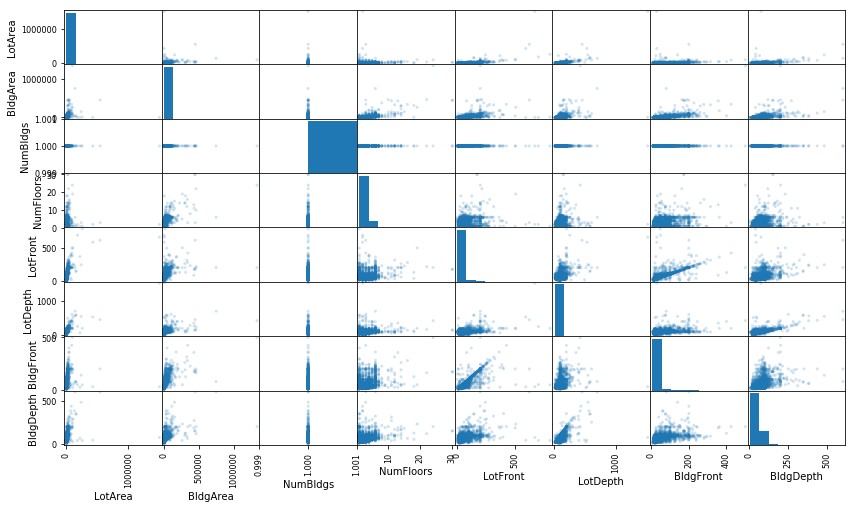

In [5]:
pd.plotting.scatter_matrix(dataReduced, alpha = 0.2, figsize = (14,8));

From this visualization, it is clear that, as might be expected, many of these variables have a linear correlation. This makes sense, since these features are all related to size. A building that has an extremely large depth will also likely have a large front. A building with more floors will likely have a higher area. 

It is clear, then, that some additional preprocessing is necessary to tease out some additional relationships. While size is of course an important factor, it is not the only way that we can predict typology. Ratios of building depth to building front may give a clue as to the shape of the building, for instance, which could be a predictor.

### Algorithms and Techniques

There are multiple clustering algorithms to consider, including K-Means clustering and Gaussian Mixture Model (GMM) clustering. While K-Means clustering is relatively easy to imlement and easy to understand, it is a hill-climbing algorithm, so the output may vary depending on the starting point. GMM allows some overlap between clusters, and also allows clusters to take on different shapes. It might be costlier to run, but it is less sensitive to outliers.

I will select GMM because this data does not have clear clusters that would result with a k-means process, so some overlap or sharing will be necessary. We also know that there are outliers in the data, and GMM is less sensitive to those.

I will follow a similar process to the Customer Segments project. In order to run this, first, I will preprocess the data. Then, I will first create clusters using an sklearn GMM algorithm. Then, I will calculate silhouette scores for multiple numbers of clusters to determine the best number. 

### Benchmark

Existing methods for classifying building typology enter the use of each building one by one, through analysis of the use. In the case of this dataset, this data is included, and will serve as the benchmark model. This data will not be used in constructing the new model, but will instead be used to compare its performance. The benchmark model should have near 100% accuracy, as each item is entered individually. We expect that the unsupervised learning model will have significantly lower accuracy than the benchmark since it will be using only the information that can be gained from physical analysis. 

## III. Methodology

### Data Preprocessing

As mentioned in the exploratory visualization section, some additional features need to be created in order to see the relationship between variables for each building. I will create two new variables:

* __Width to Depth Floor Shape ratio (FlrShape)__ = BldgFront / BldgDepth
* __Floor Area Ratio__ (FAR) = BldgArea / LotArea

In [6]:
dataReduced['FlrShape'] = dataReduced.BldgFront / dataReduced.BldgDepth
dataReduced['FAR2'] = dataReduced.BldgArea / dataReduced.LotArea

samples['FlrShape'] = dataReduced.BldgFront / dataReduced.BldgDepth
samples['FAR2'] = dataReduced.BldgArea / dataReduced.LotArea


Then, we can apply non-linear feature scaling to ensure that one feature does not outweight the others.

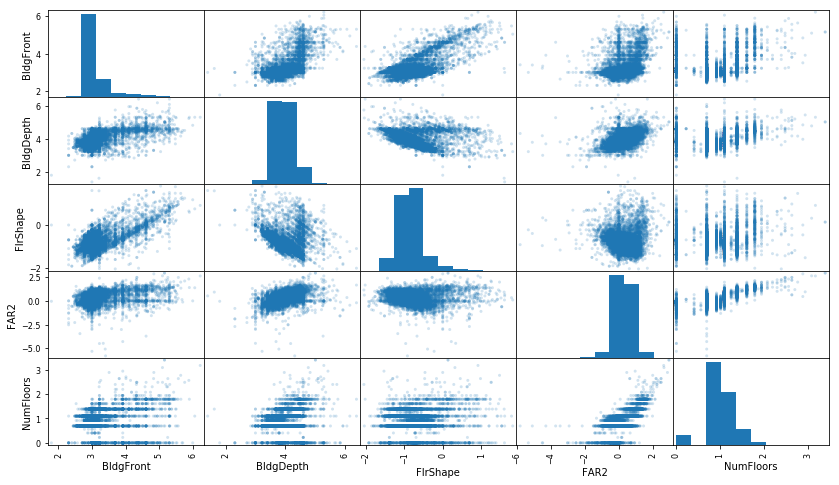

In [7]:
# Scale the reduced data using the natural logarithm
exclude = ['Address']
log_data = np.log(dataReduced[col_PhysPlus])

# Scale the sample data using the natural logarithm
log_samples = np.log(samples[col_PhysPlus])

# Produce a scatter matrix for each pair of newly-transformed features


pd.plotting.scatter_matrix(log_data, alpha = 0.2, figsize = (14,8));

We can see that Floor Shape is correlated with Building Front and that FAR is related most with Building Area and Number of floors, both of which are intuitive.

### Implementation

__Feature Transformation__
By completing a Principal Component Analysis, we can understand which dimensions best maximize variance.


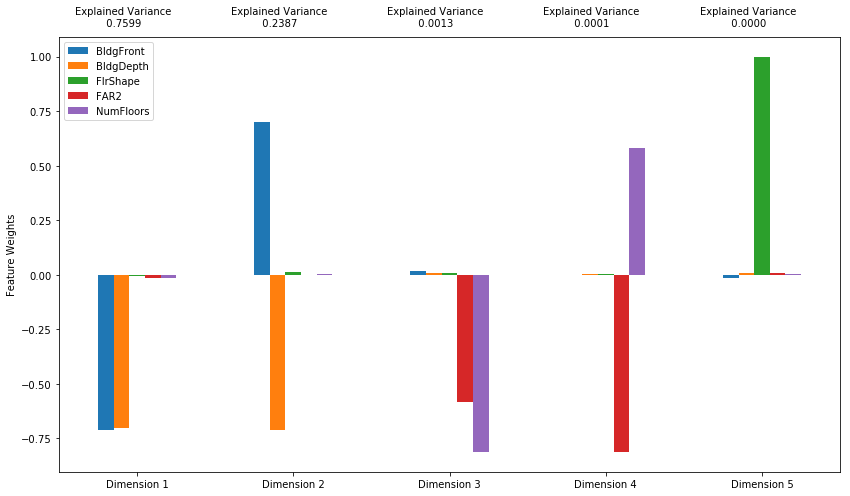

In [8]:
#Apply PCA by fitting the data with the same number of dimensions as features
from sklearn.decomposition import PCA
dataRedMin = dataReduced[col_PhysPlus]

# Eliminate rows with NaN in FAR2 column
good_data = dataRedMin[np.isfinite(dataReduced['FAR2'])]

pca = PCA()
pca.fit(good_data)

# Transform log_samples using the PCA fit above
pca_samples = pca.transform(log_samples)

# Generate PCA results plot
pca_results = vs.pca_results(good_data, pca)


In [9]:
#Display sample log-data after having a PCA transformation applied
display(pd.DataFrame(np.round(pca_samples, 4), columns = pca_results.index.values))

,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5
0,50.6219,19.9655,1.7460,-1.0786,-1.3238
1,49.8037,21.2188,-1.4237,-1.0040,0.4085
2,52.3100,19.9037,1.3585,-0.3925,-1.4302
3,49.7342,21.4138,-1.0765,-0.7893,0.6735


__Dimensionality Reduction__

TODO

In [10]:
pca = PCA(n_components=2)
pca.fit(good_data)

# Transform the good data using the PCA fit above
reduced_data = pca.transform(good_data)

# Transform log samples using the PCA fit above
pca_samples = pca.transform(log_samples)

# Create a dataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])

In [11]:
# Display sample log-data after applying PCA transformation in two dimensions
display(pd.DataFrame(np.round(pca_samples, 4), columns = ['Dimension 1', 'Dimension 2']))

,Dimension 1,Dimension 2
0,50.6219,19.9655
1,49.8037,21.2188
2,52.3100,19.9037
3,49.7342,21.4138


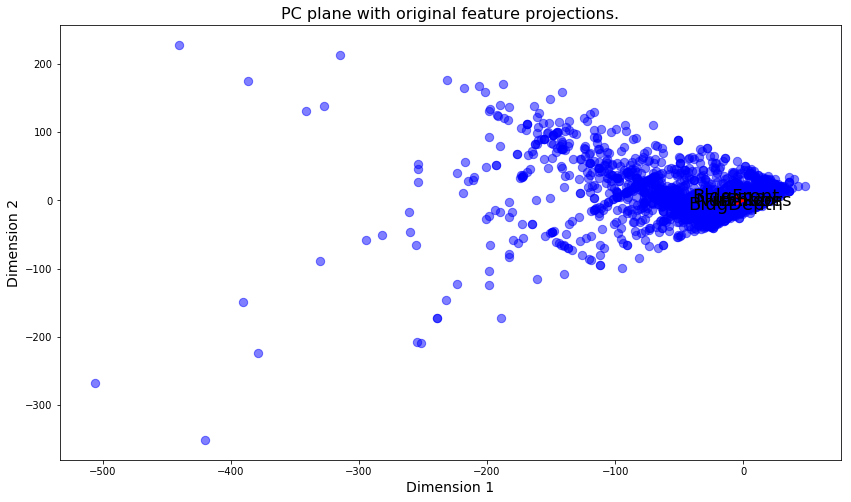

In [12]:
vs.biplot(good_data, reduced_data, pca)

In [14]:
from sklearn.mixture import GMM

def testNumClusters(numClusters):

    from sklearn.mixture import GMM
    clusterer = GMM(n_components=numClusters, random_state = 35)
    clusterer.fit(reduced_data)

    # TODO: Predict the cluster for each data point
    preds = clusterer.predict(reduced_data)

    # TODO: Find the cluster centers
    centers = clusterer.means_

    # TODO: Predict the cluster for each transformed sample data point
    sample_preds = clusterer.predict(pca_samples)

    # TODO: Calculate the mean silhouette coefficient for the number of clusters chosen
    from sklearn.metrics import silhouette_score
    score = silhouette_score(reduced_data, preds)

    print numClusters,': %.3f' % score
    return;

for i in range (2, 11):
    testNumClusters(i)
    

2 : 0.621
3 : 0.554
4 : 0.503
5 : 0.503
6 : 0.418
7 : 0.421
8 : 0.419
9 : 0.420
10 : 0.385


In [15]:
from sklearn.mixture import GMM
numClusters = 5


clusterer = GMM(n_components=numClusters, random_state = 35)
clusterer.fit(reduced_data)

# TODO: Predict the cluster for each data point
preds = clusterer.predict(reduced_data)

# TODO: Find the cluster centers
centers = clusterer.means_

# TODO: Predict the cluster for each transformed sample data point
sample_preds = clusterer.predict(pca_samples)

# TODO: Calculate the mean silhouette coefficient for the number of clusters chosen
from sklearn.metrics import silhouette_score
score = silhouette_score(reduced_data, preds)

print numClusters,': %.3f' % score




5 : 0.503


SyntaxError: 'return' outside function (<ipython-input-15-d553d0506e10>, line 22)

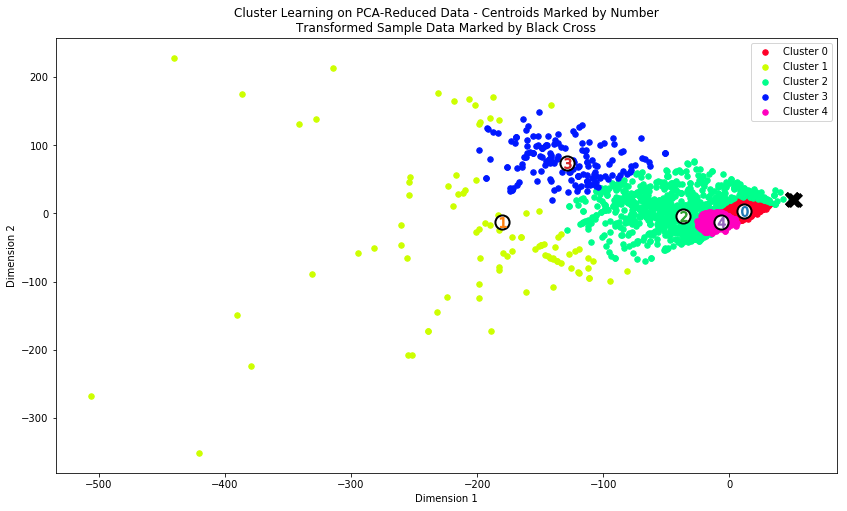

In [17]:
# Display the results of the clustering from implementation

vs.cluster_results(reduced_data, preds, centers, pca_samples)

### Refinement

TODO

## IV. Results

### Model Evaluation and Validation

TODO

### Justification

## V. Conclusion

### Free-Form Visualization

TODO

### Reflection

TODO

### Improvement

TODO

### References:

(1) https://books.google.com/books?hl=en&lr=&id=wilTAAAAcAAJ&oi=fnd&pg=PA1&dq=precis+durand&ots=hY1zElBwh2&sig=clePUvTcCCBGFLNlBVFp0j4XPJw#v=onepage&q=precis%20durand&f=false

(2) https://pdfs.semanticscholar.org/24c5/4f200302943cde042aee677956adc0b2498e.pdf

(3) http://certainmeasures.com/spatial_recognition.html

(4) https://www.kaggle.com/new-york-city/nyc-buildings

(5) Udacity MLND Customer Segment Project